# 🎬 EDA avanzado y storytelling visual con datos de Netflix
Magíster en Data Science · Visualización de Datos y Storytelling

En este notebook realizaremos un **análisis exploratorio de datos (EDA)** de nivel magíster,
combinando:

- limpieza y transformación de datos,
- creación de variables derivadas con sentido analítico,
- visualizaciones avanzadas con **Plotly** (incluyendo un diagrama de **Sankey**),
- y una síntesis narrativa de hallazgos.

El foco es conectar el **rigor analítico** con la **comunicación visual estratégica**.


## 1. descripción del dataset

Trabajaremos con el dataset público de títulos de **Netflix**, que típicamente incluye columnas como:

- `show_id`: identificador único del título.
- `type`: tipo de contenido (`Movie` o `TV Show`).
- `title`: título de la obra.
- `director`, `cast`: nombres de personas asociadas.
- `country`: países asociados a la producción.
- `date_added`: fecha de incorporación al catálogo.
- `release_year`: año de lanzamiento original.
- `rating`: clasificación de edad (ej. `TV-MA`, `PG-13`).
- `duration`: duración (minutos o número de temporadas).
- `listed_in`: géneros o categorías asignadas.
- `description`: sinopsis breve.

Además, construiremos **variables derivadas** que nos permitirán profundizar el análisis:
- país principal, número de países asociados,
- género principal,
- década de lanzamiento,
- indicadores binarios para algunos análisis.


In [1]:
# ============================================================
# 1. librerías y configuración general
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# configuración de pandas y visualización básica
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## 2. carga de datos y exploración inicial

En esta sección cargamos el dataset, revisamos su tamaño y observamos algunas filas para
entender la estructura base antes de transformar nada.


In [2]:
# ============================================================
# 2. carga y exploración inicial
# ============================================================

# se asume que el archivo 'netflix_titles.csv' está en el mismo directorio del notebook
df = pd.read_csv('netflix_titles.csv')

print(f'número de registros: {len(df):,}')
print(f'número de columnas: {df.shape[1]}')

df.head()

número de registros: 8,807
número de columnas: 12


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## 3. limpieza básica y estandarización

Aplicamos una limpieza mínima pero sistemática:

- estandarizar nombres de columnas,
- manejar valores nulos en variables clave,
- asegurar tipos adecuados,
- dejar listo el dataset para derivar nuevas variables.


In [3]:
# ============================================================
# 3. limpieza y tratamiento básico
# ============================================================

# estandarizar nombres de columnas a snake_case y sin espacios
df.columns = df.columns.str.lower().str.strip()

# revisión de valores nulos por columna
na_counts = df.isna().sum().sort_values(ascending=False)
print('valores nulos por columna:')
print(na_counts)

# completar valores faltantes en columnas clave con categorías explícitas
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Not Rated')
df['duration'] = df['duration'].fillna('Unknown')

# derivar año de lanzamiento si falta, intentando extraer desde date_added
if df['release_year'].isna().any():
    year_from_date = df['date_added'].str.extract(r'(\d{4})')[0]
    df['release_year'] = df['release_year'].fillna(year_from_date)

# asegurar tipo numérico donde corresponde
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

# eliminar filas sin año de lanzamiento, ya que dificultan el análisis temporal
df = df.dropna(subset=['release_year']).copy()
df['release_year'] = df['release_year'].astype(int)

print(f'dimensiones después de limpieza básica: {df.shape}')


valores nulos por columna:
director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64
dimensiones después de limpieza básica: (8807, 12)


## 4. construcción de variables derivadas

Para un análisis de nivel magíster es clave **aumentar la dimensionalidad semántica** del dataset,
no solo describir columnas originales. Aquí derivamos:

- `main_country`: país principal (primer país listado).
- `n_countries`: número de países asociados a una producción.
- `main_genre`: género principal (primer género listado).
- `decade`: década de lanzamiento (ej. 2010, 2000, 1990, etc.).
- `is_movie`: indicador binario para distinguir películas de series.


In [4]:
# ============================================================
# 4. creación de variables derivadas
# ============================================================

def get_first_token(value):
    # función auxiliar para obtener el primer elemento de una lista separada por coma
    if isinstance(value, str):
        return value.split(',')[0].strip()
    return np.nan

# país principal
df['main_country'] = df['country'].apply(get_first_token)

# número de países asociados
df['n_countries'] = df['country'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# género principal
df['main_genre'] = df['listed_in'].apply(get_first_token)

# década de lanzamiento
df['decade'] = (df['release_year'] // 10 * 10).astype('Int64')

# indicador binario de película
df['is_movie'] = (df['type'] == 'Movie').astype(int)

df[['type', 'main_country', 'main_genre', 'release_year', 'decade', 'n_countries', 'is_movie']].head()


,type,main_country,main_genre,release_year,decade,n_countries,is_movie
0,Movie,United States,Documentaries,2020,2020,1,1
1,TV Show,South Africa,International TV Shows,2021,2020,1,0
2,TV Show,Unknown,Crime TV Shows,2021,2020,1,0
3,TV Show,Unknown,Docuseries,2021,2020,1,0
4,TV Show,India,International TV Shows,2021,2020,1,0


## 5. análisis descriptivo general

Partimos con una vista agregada:

- distribución por tipo de contenido (películas vs series),
- evolución temporal del volumen de lanzamientos,
- países con mayor presencia en el catálogo.

Esta sección responde la pregunta: **“¿qué hay en este dataset?”**.


In [5]:
# ============================================================
# 5.1 distribución por tipo de contenido
# ============================================================

type_counts = df['type'].value_counts().reset_index()
type_counts.columns = ['type', 'count']

fig = px.bar(
    type_counts,
    x='type',
    y='count',
    title='distribución por tipo de contenido',
    labels={'type': 'tipo', 'count': 'cantidad de títulos'},
)
fig.show()

In [6]:
# ============================================================
# 5.2 evolución temporal de lanzamientos
# ============================================================

df_year = df.groupby('release_year')['show_id'].count().reset_index()
df_year.columns = ['release_year', 'n_titles']

fig = px.line(
    df_year,
    x='release_year',
    y='n_titles',
    title='evolución de la cantidad de títulos por año de lanzamiento',
    labels={'release_year': 'año de lanzamiento', 'n_titles': 'número de títulos'},
)
fig.update_traces(mode='lines+markers')
fig.show()


In [7]:
# ============================================================
# 5.3 países con más producciones
# ============================================================

top_countries = (
    df['main_country']
    .value_counts()
    .nlargest(15)
    .sort_values(ascending=True)
)

fig = px.bar(
    x=top_countries.values,
    y=top_countries.index,
    orientation='h',
    title='top 15 países con más producciones en netflix',
    labels={'x': 'cantidad de títulos', 'y': 'país principal'},
)
fig.show()


## 6. análisis multivariante

Pasamos de lo unidimensional a lo multivariante, explorando:

- cómo se distribuyen **tipos de contenido por país**,
- cómo evolucionan **películas vs series por década**,
- correlaciones entre variables derivadas.

Aquí buscamos responder: **“¿cómo se combinan estas dimensiones?”**.


In [8]:
# ============================================================
# 6.1 distribución de tipos por país principal
# ============================================================

country_type = (
    df.groupby(['main_country', 'type'])
    .size()
    .reset_index(name='count')
)

# para evitar ruido, nos quedamos con países con al menos 50 títulos
valid_countries = country_type.groupby('main_country')['count'].sum()
valid_countries = valid_countries[valid_countries >= 50].index
country_type_filtered = country_type[country_type['main_country'].isin(valid_countries)]

fig = px.bar(
    country_type_filtered,
    x='main_country',
    y='count',
    color='type',
    barmode='group',
    title='distribución de tipos de contenido por país (países con ≥ 50 títulos)',
    labels={'main_country': 'país principal', 'count': 'cantidad de títulos', 'type': 'tipo de contenido'},
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [9]:
# ============================================================
# 6.2 evolución de películas vs series por década
# ============================================================

decade_type = (
    df.groupby(['decade', 'type'])
    .size()
    .reset_index(name='count')
    .dropna(subset=['decade'])
)

fig = px.area(
    decade_type,
    x='decade',
    y='count',
    color='type',
    title='evolución de películas y series por década',
    labels={'decade': 'década', 'count': 'cantidad de títulos', 'type': 'tipo de contenido'},
)
fig.show()


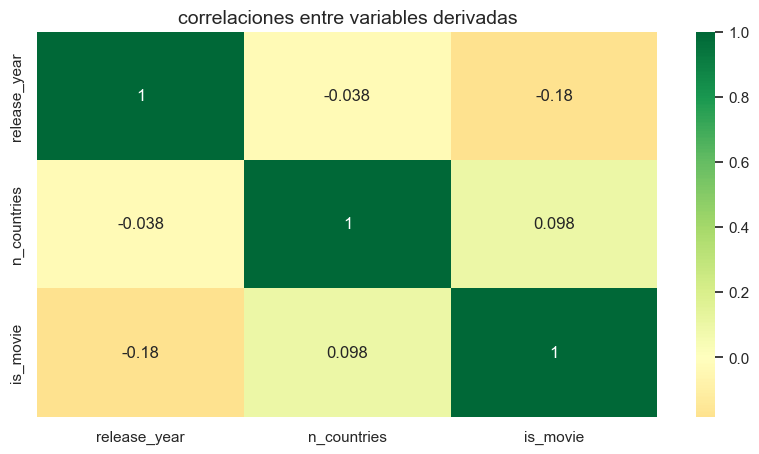

In [10]:
# ============================================================
# 6.3 correlaciones entre variables derivadas
# ============================================================

num_cols = ['release_year', 'n_countries', 'is_movie']
corr = df[num_cols].corr()

sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0)
plt.title('correlaciones entre variables derivadas')
plt.show()


## 7. visualización avanzada: sankey país → tipo → género

Ahora construimos una visualización de **flujo** que conecte:

- país principal (`main_country`),
- tipo de contenido (`type`),
- género principal (`main_genre`).

El diagrama de Sankey nos permite ver, por ejemplo:

- qué países concentran más películas vs series,
- qué géneros dominan en cada tipo y país,
- qué combinaciones país–tipo–género son estructuralmente relevantes.

Para mantener la legibilidad, filtraremos combinaciones poco frecuentes.


In [11]:
# ============================================================
# 7. preparación de datos para sankey (país → tipo → género)
# ============================================================

# agregamos conteos por combinación país principal, tipo y género principal
sankey_df = (
    df.groupby(['main_country', 'type', 'main_genre'])
    .size()
    .reset_index(name='count')
)

# filtramos combinaciones poco frecuentes para evitar ruido visual
sankey_df = sankey_df[sankey_df['count'] >= 20].copy()

print(f'número de combinaciones país-tipo-género usadas en el sankey: {len(sankey_df)}')
sankey_df.head()


número de combinaciones país-tipo-género usadas en el sankey: 84


,main_country,type,main_genre,count
7,Argentina,Movie,Dramas,24
65,Canada,Movie,Children & Family Movies,39
66,Canada,Movie,Comedies,31
67,Canada,Movie,Documentaries,33
68,Canada,Movie,Dramas,37


In [12]:
# ============================================================
# 7.2 construcción de nodos y enlaces
# ============================================================

# creamos el conjunto de nodos únicos (países, tipos y géneros)
all_nodes = pd.Series(
    pd.concat([
        sankey_df['main_country'],
        sankey_df['type'],
        sankey_df['main_genre']
    ])
).unique().tolist()

node_map = {name: idx for idx, name in enumerate(all_nodes)}

# flujos país → tipo
sources_country_type = sankey_df['main_country'].map(node_map)
targets_country_type = sankey_df['type'].map(node_map)
values_country_type = sankey_df['count']

# flujos tipo → género
sources_type_genre = sankey_df['type'].map(node_map)
targets_type_genre = sankey_df['main_genre'].map(node_map)
values_type_genre = sankey_df['count']

# concatenamos ambos conjuntos de enlaces
source_nodes = pd.concat([sources_country_type, sources_type_genre]).reset_index(drop=True)
target_nodes = pd.concat([targets_country_type, targets_type_genre]).reset_index(drop=True)
values_all = pd.concat([values_country_type, values_type_genre]).reset_index(drop=True)

len(all_nodes), len(source_nodes), len(target_nodes)


(46, 168, 168)

In [13]:
# ============================================================
# 7.3 diagrama de sankey con plotly
# ============================================================

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color='black', width=0.5),
                label=all_nodes,
                color='rgba(31, 119, 180, 0.6)',
            ),
            link=dict(
                source=source_nodes,
                target=target_nodes,
                value=values_all,
            ),
        )
    ]
)

fig.update_layout(
    title_text='flujo de contenido en netflix: país → tipo → género',
    font_size=12,
)
fig.show()


## 8. síntesis de hallazgos e implicancias narrativas

A partir del análisis visual realizado, podemos destacar algunos patrones típicos (que dependerán
del dataset concreto de Netflix que estés usando):

- crecimiento marcado del número de títulos a partir de la década de 2010, con fuerte presencia de películas.
- concentración geográfica de la producción en unos pocos países (por ejemplo, Estados Unidos, India, Reino Unido).
- diferencias estructurales en la mezcla de géneros por país y tipo de contenido:
  - ciertos países dominan géneros como **drama** o **comedia** en películas,
  - otros muestran mayor peso en géneros **románticos** o **familiares** en series.
- las variables derivadas (década, país principal, género principal) permiten construir narrativas de
  cambio en el tiempo y diversificación del catálogo.

Desde la perspectiva de **storytelling de datos**:

- el análisis EDA sirve como base para formular **historias visuales** sobre la estrategia de contenido de Netflix.
- el diagrama de Sankey conecta tres niveles semánticos (origen → formato → temática), lo que facilita
  explicar decisiones de programación o recomendaciones personalizadas.
- estos hallazgos podrían transformarse en dashboards ejecutivos, o en narrativas específicas
  para audiencias de negocio (por ejemplo: expansión regional, diversidad de catálogo, etc.).


## 9. extensiones posibles

Algunas extensiones interesantes para proyectos de magíster podrían ser:

- incorporar análisis de **duración** (minutos o temporadas) y relacionarlo con ratings o géneros,
- construir redes de co-ocurrencia de actores o directores y analizarlas con **Gephi**,
- aplicar técnicas de **NLP** a las descripciones (`description`) para detectar temas latentes,
- transformar este EDA en una app de **Streamlit** que permita:
  - filtrar por país, década, género,
  - ver cómo cambia el sankey en función de los filtros,
  - ofrecer una narrativa guiada para distintos stakeholders.

Estas extensiones conectan el análisis exploratorio con la creación de **productos de datos**
que agregan valor organizacional.
